# Difference between MSE and Cross Entropy in Regression Example

MSE와 Cross Entropy의 차이점들중에 학습속도에 관한 내용에 관한 내용은 있지만 데이터에 따른 차이점은 없는듯 하여 관련 문서를 만들게 되었습니다.

기본적으로 차이점은 MSE이는 예측값과 y값의 차이를 구하는 것이고, CE의 probablistic prediction에 사용됩니다. <br>
예를 들어서 [자동차, 비행기, 자전거] 같은 사물인식에 대한 데이터는..  $ \hat{y} = [0.1, 0.2, 0.8] $ 그리고 $ y = [0, 0, 1] $ 이라면 다음과 같이 잘 작동을 합니다. 

$$ \begin{eqnarray}
\text{cross entropy} &=& -\left( 0 \cdot \log(\frac{1}{10}) + 0 \cdot \log(\frac{2}{10}) + 1 \cdot \log(\frac{8}{10}) \right) \\
&=& - \left( 0 + 0 - 0.22314 \right) \\
&=& 0.22314
\end{eqnarray} $$

하지만 예를 들어서 Linear Regression + Cross Entropy를 계산시 $ y = [12, -4, 0.12] $ 그리고 $ \hat{y} = [0.1, 0.2, 0.7]  $ 라면

$$ \begin{eqnarray}
\text{cross entropy} &=& -\left( 12 \cdot \log(0.1) + (-4) \cdot \log(0.2) + 0.12 \cdot \log(0.7) \right) \\
&=& 21.236070
\end{eqnarray} $$

문제는 CE가 $y$ 값과 $ \log(\hat{y}) $ 의 곱을 하게 되는데 계속 값이 gradient descent를 거치게 되면서 계속 작아지거나 커지거나 하게됩니다. 이론적으로는 잘 돌아가겠지만, 컴퓨터환경에서 underflow 또는 overflow가 발생하면서 $ \log(\hat{y}) $ 를 거칠때 -inf 또는 nan가 나오게 됩니다. 결국 잘동을 안합니다. (MSE에서는 잘 작동함)

### 원인

cross entropy의 공식은 다음과 같습니다. 

$$ H(p, q) = - \sum_{i=1} p(y_i) \log q(\hat{y_i})  $$

즉 $ p(y_i) $ 그리고 $ q(\hat{y_i}) $ 모두 0~1사이의 확률값을 갖어야 합니다.<br>
이때 1이상 넘거나, 0이하인 경우 log 함수를 거치면서 -inf 또는 nan값이 나오게 되고 학습이 안되게 됩니다. 

실제 문제가 될 수 있는 부분은 Data 전처리시 Standardization의 사용 (음수 값으로 scale 될 수 있음)<br>
또는 MinMax Normalization의 사용에서 추후 들어온 값이 그 이상 또는 그 이하일때 실제 서비스에서 문제가 생길 요인이 있습니다. 

In [1]:
%pylab inline
import numpy as np
import tensorflow as tf
import pandas as pd

from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy
from sklearn import metrics

Populating the interactive namespace from numpy and matplotlib


## Create Interactive Session

In [2]:
init_op = tf.global_variables_initializer()

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.001, allow_growth=True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(init_op)

# Linear Regression Data

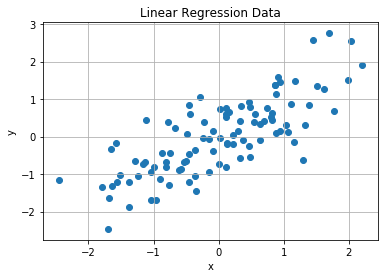

In [20]:
data = np.genfromtxt('../../data/linear-regression/linear-regression.csv', delimiter=',')

# Scaling
scaler = StandardScaler()
data = scaler.fit_transform(data)

x = data[:, 0]
y = data[:, 1] 
scatter(x, y)
grid()
xlabel('x')
ylabel('y')
title('Linear Regression Data')

d = pd.DataFrame(data)
d.to_csv('./data.csv')

In [4]:
def next_batch(x, y, size=10):
    N = x.shape[0]
    idx = np.random.randint(0, N-size)
    return x[idx: idx+size], y[idx: idx+size]

sample_x, sample_y = next_batch(x, y)
print(sample_x.shape, sample_y.shape)

(10,) (10,)


# Regression Model

In [17]:
def mean_squared_error(targets, preds):
    delta = targets - preds
    cost = tf.reduce_mean(delta**2)
    return delta, cost

def sigmoid_cross_entropy(targets, preds):
    """
    위의 prediction에서 음수도 나올수 있는데.. 이때 음수를 log에 넣으면 nan이 떠버립니다.
    따라서 sigmoid를 통해서 0~1사이의 값으로 보정을 해줍니다. 
    """
    sig = tf.sigmoid(preds)
    cost = -tf.reduce_sum(targets * tf.log(sig))
    return sig, cost

def sigmmmoid_cross_entropy2(targets, preds):
    return tf.nn.sigmoid_cross_entropy_with_logits(logits=preds, labels=targets)
    
# Select Cost FUnction
cost_function = sigmoid_cross_entropy


# Create Linear Regression Model
input_x = tf.placeholder('float', name='input_x')
input_y = tf.placeholder('float', name='input_y')

w = tf.Variable([-0.85918599], name='weights') # [-0.4775362]
b = tf.Variable(tf.zeros([1]), name='bias') # [ 0.]

pred = tf.add(tf.multiply(input_x, w), b, name='prediction')
cost1, cost2 = cost_function(input_y, pred)
grad = tf.train.MomentumOptimizer(learning_rate=0.05, momentum=0.5).minimize(cost2)

init_op = tf.global_variables_initializer()
sess.run(init_op)

In [7]:
sess.run(w, feed_dict={input_x: x, input_y: y})

array([-0.85918599], dtype=float32)

### Linear Regression with Cross Entropy

특히 log를 사용하는 cross entropy의 경우에는 classification 문제가 아닌 regression문제에서는 다음과 같은 오류가 날 수 있습니다.

weights: 27639.2773 | bias: 545.5129 | loss: 100.0000, -0.0000 | sum of predicts: 135371856.0000
weights: 32245.9668 | bias: 636.4317 | loss: 100.0000, -0.0000 | sum of predicts: 157934544.0000
weights: 34549.3125 | bias: 681.8911 | loss: 100.0000, -0.0000 | sum of predicts: 169215904.0000
weights: 35700.9844 | bias: 704.6208 | loss: 100.0000, -0.0000 | sum of predicts: 174856560.0000
weights: 36276.8203 | bias: 715.9857 | loss: 100.0000, -0.0000 | sum of predicts: 177676896.0000
weights: 36564.7383 | bias: 721.6681 | loss: 100.0000, -0.0000 | sum of predicts: 179087072.0000
weights: 36708.6992 | bias: 724.5093 | loss: 100.0000, -0.0000 | sum of predicts: 179792160.0000
weights: 36780.6797 | bias: 725.9299 | loss: 100.0000, -0.0000 | sum of predicts: 180144704.0000
weights: 36816.6680 | bias: 726.6402 | loss: 100.0000, -0.0000 | sum of predicts: 180320960.0000
weights: 36834.6641 | bias: 726.9954 | loss: 100.0000, -0.0000 | sum of predicts: 180409104.0000
weights: 36843.6602 | bias: 72

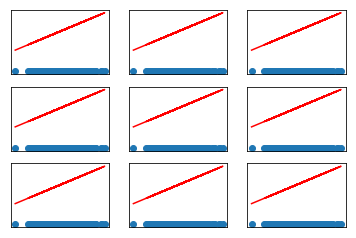

In [19]:
def run(verbose=True, n_iter=10):
    normal_y_pred = None
    graph_count = 1
    for i in range(1, n_iter):
        
        sess.run(grad, feed_dict={input_x: x, input_y: y})
        y_pred, loss1, loss2, _w, _b = sess.run([pred, cost1, cost2, w, b], feed_dict={input_x: x, input_y: y})

        if verbose:
            _w, _b = _w[0], _b[0]
            loss1 = np.sum(loss1)
            _sum_pred = np.sum(y_pred)
            print(f'weights: {_w:.4f} | bias: {_b:.4f} | loss: {loss1:.4f}, {loss2:.4f} | sum of predicts: {_sum_pred:.4f}')

        if np.isnan(y_pred).any():
            break
        
        if i % (n_iter/10) == 0:
            axes = subplot(3, 3, graph_count)
            axes.get_xaxis().set_visible(False)
            axes.get_yaxis().set_visible(False)

            scatter(x, y)
            plot(x, y_pred, color='red')
            grid()
            axes.grid()
            
            graph_count += 1
        
run(n_iter=20)

### Linear Regression with Mean Squared Error

반면에 Mean Squared Error의 경우에는 Regression에서 문제없이 처리를 잘 해냅니다.

weights: -0.6959 | bias: 0.0000 | loss: -0.0000, 2.5611 | sum of predicts: 0.0000
weights: -0.4673 | bias: -0.0000 | loss: 0.0000, 1.9415 | sum of predicts: 0.0000
weights: -0.2289 | bias: -0.0000 | loss: 0.0000, 1.4066 | sum of predicts: 0.0000
weights: -0.0094 | bias: -0.0000 | loss: 0.0000, 1.0147 | sum of predicts: -0.0000
weights: 0.1786 | bias: -0.0000 | loss: 0.0000, 0.7555 | sum of predicts: -0.0000
weights: 0.3322 | bias: -0.0000 | loss: -0.0000, 0.5963 | sum of predicts: 0.0000
weights: 0.4531 | bias: -0.0000 | loss: 0.0000, 0.5042 | sum of predicts: -0.0000
weights: 0.5456 | bias: -0.0000 | loss: 0.0000, 0.4534 | sum of predicts: 0.0000
weights: 0.6147 | bias: -0.0000 | loss: 0.0000, 0.4266 | sum of predicts: -0.0000


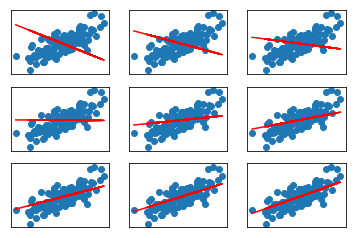

In [272]:
run(verbose=True)